In [14]:
import kaggle
import os
import zipfile
import pandas as pd
import seaborn as sns

In [ ]:
# Download data
COMPETITION_NAME = 'elo-merchant-category-recommendation'
DOWNLOAD_FILES = True
UNZIP_FILES = True

kaggle_api = kaggle.KaggleApi()
kaggle_api.authenticate()

if DOWNLOAD_FILES:
    kaggle_api.competition_download_files(competition=COMPETITION_NAME, path='data', quiet=False)

if UNZIP_FILES:
    for item in os.listdir('data',):
        if item.endswith('zip'):
            file_name = os.path.abspath('data/' + item)
            zip_ref = zipfile.ZipFile(file_name)
            zip_ref.extractall('data/')
            zip_ref.close()
            os.remove(file_name)

In [2]:
# Read data
merchants = pd.read_csv('data/merchants.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
hist_trans = pd.read_csv('data/historical_transactions.csv')

## Data manipulation

In [22]:
train['first_active_year'] = train.first_active_month.str[:4]
train['first_active_month_m'] = train.first_active_month.str[5:]

## Explore train

In [12]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target'],
      dtype='object')

In [23]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_year,first_active_month_m
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,06
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,01
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,08
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,09
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


#### first_active_month

In [17]:
print(train.first_active_month.min())
print(train.first_active_month.max())

2011-11
2018-02


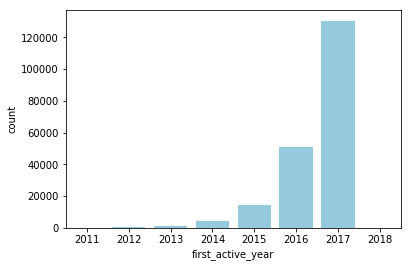

In [28]:
sns.countplot(x='first_active_year', data=train, color='skyblue')

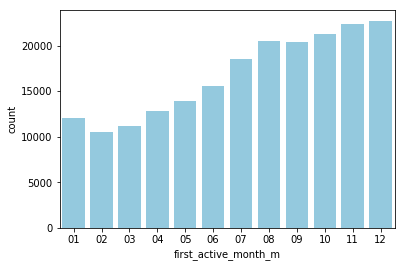

In [34]:
sns.countplot(x='first_active_month_m', data=train, color='skyblue')

In [56]:
year_months = train.groupby(['first_active_year','first_active_month_m']).size()
year_months.groupby('first_active_year').apply(lambda x: 100*x/x.sum()).groupby('first_active_month_m').mean()

first_active_month_m
01    19.471427
02     3.731123
03     4.763369
04     6.154659
05     7.960435
06     7.462820
07     9.419159
08    10.438816
09    10.586543
10    10.746234
11    22.075000
12    13.905195
dtype: float64